**Qustion: Can IMU data of a frame be used to predict the active duty cycles (meaningful states detected)?** 

Here we treat it as a binary classification problem.  IMU data -> active cycle (T/F)

In [70]:
from __future__ import absolute_import, division, print_function

import collections
import glob
import itertools
import json
import matplotlib
rc_fonts = {
    "font.weight": 800,
    "font.family": "serif",
    "font.serif": ["Times"], # use latex's default
    "font.sans-serif": ["DejaVu Sans"],
    "text.usetex": True,
}
matplotlib.rcParams.update(rc_fonts)
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import re
import sqlalchemy as sa

from rmexp import dbutils, config
from rmexp.schema import models

In [2]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from scipy.ndimage.filters import gaussian_filter1d

/home/junjuew/work/resource-management/conda-env-rmexp/lib/python2.7/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [3]:
def insert_or_update_one(sess, model, keys_dict, vals_dict):
    record = sess.query(model).filter_by(**keys_dict).one_or_none()
    if record is not None:
        record.update(vals_dict)
    else:
        create_dict = {}
        create_dict.update(keys_dict)
        create_dict.update(vals_dict)
        record = model(**create_dict)
        sess.add(record)
    return record

In [75]:
APP = "lego"

if APP == 'lego':
    ## settings for Lego
    # 5 and 8 lack patterns
    TRAIN_TRACES = ['lego-tr' + str(i) for i in (1, 2, 3, 4, 6)]
    TEST_TRACES = ['lego-tr' + str(i) for i in (1, 2, 3, 4, 6)]
    def filter_active(ss_df):
        return ss_df['val'].str.contains('\[\[')
    
elif APP == 'pingpong':
    ## settings for Ping Pong
    # 6-10 are longer traces Junjue and zf recorded
    TRAIN_TRACES = ['pingpong-tr' + str(i) for i in (6, 7, 8, 9, 10)]
    TEST_TRACES = ['pingpong-tr' + str(i) for i in (6, 7, 8, 9, 10)]
    def filter_active(ss_df):
        return ~(ss_df['val'].str.contains('Cannot find table')
                | ss_df['val'].str.contains('Detected table too small')
                | ss_df['val'].str.contains('Table top line')
                | ss_df['val'].str.contains('Table doesn\'t occupy')
                | ss_df['val'].str.contains('Angle between two side')
                | ss_df['val'].str.contains('Valid area too small')
               )

In [76]:
# load IMU csv files into MySQL

def load_IMU_to_DB(trace_name, base_dir):
    trace_num = re.search('\d+', trace_name).group(0)
    csv_name = glob.glob(os.path.join(base_dir,
                                      trace_num, '*.csv'))[0]
    print("Using file as IMU data:", csv_name)
    df = pd.read_csv(csv_name,index_col='frame_id')
    df['sensor_timestamp'] = pd.to_datetime(df['sensor_timestamp'])
    
    new = 0
    for row in df.itertuples():
        keys_dict = {'name': trace_name,
                     'trace': trace_num,
                     'index': row.Index
                    }
        vals_dict = {'sensor_timestamp': row.sensor_timestamp.to_pydatetime(),
                     'rot_x': row.rot_x,
                     'rot_y': row.rot_y,
                     'rot_z': row.rot_z,
                     'acc_x': row.acc_x,
                     'acc_y': row.acc_y,
                     'acc_z': row.acc_z
                    }
        
        insert_or_update_one(sess, models.IMU, keys_dict, vals_dict)

    print("Updated: ", len(sess.dirty))
    print("New: ", len(sess.new))
    sess.commit()

# sess = dbutils.get_session()
# for trace_name in set(TRAIN_TRACES + TEST_TRACES):
#     load_IMU_to_DB(trace_name, '/home/junjuew/work/resource-management/data/pingpong-trace')
# sess.close()

In [77]:
# calibration data using zero-movement readings
#  select avg(rot_x), avg(rot_y), avg(rot_z), avg(acc_x), avg(acc_y), avg(acc_z) from IMU where name = "lego-tr0";
IMU_CALIBRATE = [0.0006005733204134366, -0.0010699289405684755, 0.0010396479328165374,
                -0.4246709463824289, 10.076913759689923, 0.31374152131782945]

# the -tr0 IMU readings from lego and pingpong are quite different ...

In [78]:
# reading from MySQL using Pandas API

def get_SS_pd(trace_name):
    df = pd.read_sql('SELECT * FROM SS WHERE name = %s', dbutils.engine, params=[trace_name,])
    df['index'] = df['index'].astype(int) - 1   # SS's index counts from 1
    df = df.sort_values('index')
    return df
    
def get_IMU_pd(trace_name):
    df = pd.read_sql('SELECT * FROM IMU WHERE name = %s', dbutils.engine, params=[trace_name,])
    df['index'] = df['index'].astype(int)
    df = df.sort_values('index')
    return df

In [79]:
# Classifiction problem: 
# Features: 6 IMU readings per frame -> transform_func -> X
# Label y: 0 - passive, 1 - active.
# use SVM with GridSearch

def get_raw_Xy(trace, calibrate=True):
    imu_df = get_IMU_pd(trace)
    ss_df = get_SS_pd(trace)
    
    # SS sometimes has one more frame than IMU, drop it
    ss_df = ss_df[ss_df['index'] <= imu_df['index'].max()]
    
    use_imu_cols = ['rot_x','rot_y','rot_z','acc_x','acc_y','acc_z']
    X1 = imu_df[use_imu_cols].values
    if calibrate:
        # adjust for calibration
        X1 = X1 - np.array(IMU_CALIBRATE)
    
    y1 = np.zeros_like(X1[:, 0])
    active_inds = ss_df[filter_active(ss_df)]['index'].values
    y1[active_inds] = 1 
    print("%s has %d/%d active/total frames" % (trace, np.count_nonzero(y1), y1.shape[0]))
    return X1, y1


def train_clf(trace_names, 
              svm_kargs={}, 
              X_transform_func=lambda x: x, 
              param_grid = {'svm__C': [1., 10.], 'svm__kernel': ['linear',]}):
    Xs = []
    ys = []
    
    for trace in trace_names:
        X1, y1 = get_raw_Xy(trace)
        X1 = X_transform_func(X1)
        Xs.append(X1)
        ys.append(y1)
    
    X = np.vstack(Xs)
    y = np.concatenate(ys)
    print(X.shape)
    print("Total frames: ", X.shape[0], "Active frames: ", np.count_nonzero(y))
    
    clf = Pipeline([
        ('scaler', StandardScaler(with_mean=True, with_std=True)),
        ('svm', SVC(**svm_kargs)),
    ])
     
    clf = GridSearchCV(clf, param_grid=param_grid, cv=5, n_jobs=4)

    clf.fit(X, y)
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
#     print("Training confusion matrix:\n", cm)
    return clf, cm, (X, y, y_pred)

def eval_clf(clf, trace_names, X_transform_func=lambda x:x):
    Xs = []
    ys = []
    for trace in trace_names:
        X1, y1 = get_raw_Xy(trace)
        X1 = X_transform_func(X1)
        Xs.append(X1)
        ys.append(y1)
        
    X = np.vstack(Xs)
    y = np.concatenate(ys)
    
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    return cm, (X, y, y_pred)

In [80]:
# manually engineered features
# select acc_x, acc_y, Gaussian smooth, and substract cummulative mean

def past_windowed_1d(x, size, func):
    # output[i] -> func(x[i-size+1:i+1])
    # aka windowed function on the past `size` frames
    # should only call on one trace
    assert x.ndim == 1
    rv = []
    for i in range(x.shape[0]):
        wind = x[max(0, i - size + 1): i+1]  # including i
        rv.append(func(wind))
        
    return np.array(rv)

def transform_acc_x(X_imu6):
    accx = X_imu6[:,3]  # acc_x
    accy = X_imu6[:,4] # acc_y
    accz = X_imu6[:,4] # acc_z
    
    accx_smooth_mean = past_windowed_1d(accx, accx.shape[0],
                                   lambda w: gaussian_filter1d(w, 10)[-1] - np.mean(w))
    accy_smooth_mean = past_windowed_1d(accy, accy.shape[0],
                                   lambda w: gaussian_filter1d(w, 10)[-1] - np.mean(w))
    accz_smooth_mean = past_windowed_1d(accz, accz.shape[0],
                                   lambda w: gaussian_filter1d(w, 10)[-1] - np.mean(w))
    
    X_combined = np.stack([accx_smooth_mean, accy_smooth_mean, accz_smooth_mean], axis=1)
    return X_combined

In [84]:
# tune weight of label 1 to trade off FN and FP
# on average 30% frames are active for Lego

weights = np.arange(2., 12., 2.)
result_df = pd.DataFrame()

for w in weights:
    print("weight:", w)
    svm_kargs = {'class_weight': {0: 1.0, 1: w}, 'random_state': 42}
    clf, cm, _ = train_clf(TRAIN_TRACES, X_transform_func=transform_acc_x, svm_kargs=svm_kargs)
    cm, _ = eval_clf(clf, TEST_TRACES, X_transform_func=transform_acc_x)
    print("Eval cm:\n", cm)
    result_df = result_df.append({'weight': w, 'confusion_matrix': cm, 'params': clf.best_params_}, ignore_index=True)

print(result_df)

weight: 2.0
lego-tr1 has 517/2605 active/total frames
lego-tr2 has 969/2982 active/total frames
lego-tr3 has 962/2858 active/total frames
lego-tr4 has 736/3110 active/total frames
lego-tr6 has 1157/4084 active/total frames
(15639, 3)
Total frames:  15639 Active frames:  4341
lego-tr1 has 517/2605 active/total frames
lego-tr2 has 969/2982 active/total frames
lego-tr3 has 962/2858 active/total frames
lego-tr4 has 736/3110 active/total frames
lego-tr6 has 1157/4084 active/total frames
Eval cm:
 [[8507 2791]
 [1451 2890]]
weight: 4.0
lego-tr1 has 517/2605 active/total frames
lego-tr2 has 969/2982 active/total frames
lego-tr3 has 962/2858 active/total frames
lego-tr4 has 736/3110 active/total frames
lego-tr6 has 1157/4084 active/total frames
(15639, 3)
Total frames:  15639 Active frames:  4341
lego-tr1 has 517/2605 active/total frames
lego-tr2 has 969/2982 active/total frames
lego-tr3 has 962/2858 active/total frames
lego-tr4 has 736/3110 active/total frames
lego-tr6 has 1157/4084 active/to

In [85]:
# Retrain using a chosen trade-off
if APP == 'lego':
    W = 8.
elif APP == 'pingpong':
    W = 2.
clf, cm, _ = train_clf(TRAIN_TRACES, 
                        X_transform_func=transform_acc_x,
                        svm_kargs={'class_weight': {0: 1.0, 1: W}, 'random_state': 42, 'verbose': True},
                        param_grid = {'svm__C': [1.,], 'svm__kernel': ['linear',]})
print(cm)
clf = clf.best_estimator_
with open('IMU_' + APP + '_clf.pkl', 'w') as f:
    pickle.dump(clf, f)
print("OK")

lego-tr1 has 517/2605 active/total frames
lego-tr2 has 969/2982 active/total frames
lego-tr3 has 962/2858 active/total frames
lego-tr4 has 736/3110 active/total frames
lego-tr6 has 1157/4084 active/total frames
(15639, 3)
Total frames:  15639 Active frames:  4341
[LibSVM][[2699 8599]
 [ 129 4212]]
OK


In [86]:
# Impact on latency of detecting state change compared to oracle
def get_state_change_frames(ss_df, k=5):
    # returns dict(ss -> first detection of change)
    # require k consecutive frames to declare state change

    ss_df = ss_df.reset_index(drop=True)  # reset Index to row id
    state_change = dict()
    
    if APP == 'lego':
        cur_state = None
        cur_count = 0

        # only count "useful" SS
        for r in ss_df.itertuples():
            ss, frame_id = r.val, r.index
            if ss not in state_change and '[[' in ss:
                if ss == cur_state:
                    cur_count += 1
                    if cur_count >= k:
                        state_change[ss] = frame_id # commit
                else:
                    cur_state = ss # change tracking state
                    cur_count = 0
            else:
                cur_state = None
                cur_count = 0
                
    elif APP == 'pingpong':
        k_active = 5
        k_passive = 30
        cur_state_active = False
        cur_count = 0
        active_phase = 0
        prev_frame_id = -1
        
        for r in ss_df.itertuples():
            ss, frame_id = r.val, r.index
            
            if frame_id - prev_frame_id > 1:
                # IMU suppressed frames. as if they are all passive frames
                if cur_state_active:
                    if frame_id - 1 - prev_frame_id >= k_passive:
                        cur_state_active = False
                        cur_count = 0
                    else:
                        cur_count += frame_id - 1 - prev_frame_id
                else:
                    cur_count = 0  # just extending passive streak
            
            active = True
            for pat in ['Cannot find table', 'Detected table too small', 'Table top line', 
                        'Table doesn\'t occupy', 'Angle between two side', 'Valid area too small']:
                if pat in ss:
                    active = False
                    break
            
            if cur_state_active ^ active:
                cur_count += 1
                if active and cur_count >= k_active: # commit
                    cur_state_active = True
                    cur_count = 0
                    new_state = 'active' + str(active_phase)
                    active_phase += 1
                    state_change[new_state] = frame_id
                elif not active and cur_count >= k_passive:
                    cur_state_active = False
                    cur_count = 0
                else:
                    pass
            else:
                cur_count = 0
                
            prev_frame_id = frame_id
            
    
    return state_change


def compare_state_change_latency(gt_dict, test_dict):
    if APP == 'lego':
        return dict([(k, test_dict.get(k, float('inf')) - gt_dict[k]) for k in gt_dict])
    elif APP == 'pingpong':
        last_gt_change = None
        ret = {}
        gt_points = np.sort(np.array(gt_dict.values()))
        for k, v in test_dict.iteritems():
            gt_change = gt_points[gt_points <= v][-1]
            if gt_change > last_gt_change:
                ret[k] = v - gt_change
                last_gt_change = gt_change
            else:
                pass # false change
            
        return ret
            
    
def eval_load_and_latency(traces, clf):
    df = pd.DataFrame()
    for trace_name in traces:
        print(trace_name)
        ss_df = get_SS_pd(trace_name)

        cm, (_, y, y_pred) = eval_clf(clf, [trace_name,], X_transform_func=transform_acc_x)
        tn, fp, fn, tp = cm.ravel()
        
        r = {
            'trace_name': trace_name,
            'dropped_total': 1. * (tn + fn) / (tn+fp+fn+tp),
            'dropped_active': 1. * (fn) / (tp + fn),
            'dropped_passive': 1. * (tn) / (tn + fp)
        }
    
        # plot
        plt.figure(figsize=(5, 2.5))
        plt.plot(y[::], 'b.', label='GT frames', markersize=4)
        plt.plot(y_pred[::] - .1, 'r.', label='IMU-based frames', markersize=4)
        
        
        if APP == 'lego':
            gt_state_change = get_state_change_frames(ss_df)
            imu_filtered_df = ss_df.iloc[np.nonzero(y_pred)]
            imu_filtered_state_change = get_state_change_frames(imu_filtered_df)
            latency = compare_state_change_latency(gt_state_change, imu_filtered_state_change)
            
            print(json.dumps(gt_state_change, indent=4))
            print(json.dumps(imu_filtered_state_change, indent=4))
            print(json.dumps(latency, indent=4))
            
            plt.vlines(gt_state_change.values(), .6, 1.2, 'k', label='GT State change')
            plt.vlines(imu_filtered_state_change.values(), -.2, .5, 'k', linestyle='dotted',
                       label='IMU-based State change')
            r.update({
                'change_delay_frames_mean': np.mean(latency.values()),
                'change_delay_frames_max': np.max(latency.values())
            })

        plt.yticks([0, 1], ['Passive', 'Active'])
        plt.xlabel('Frame Sequence')
        plt.legend(loc='lower center', bbox_to_anchor=(.5, 1.0), ncol=2)
        plt.tight_layout()
        plt.savefig('fig-imu-%s.pdf' % trace_name, bbox_inches='tight')
#         plt.title("Ground truth vs. IMU-based Suppression (trace: %s)" % trace_name)

        df = df.append(r, ignore_index=True)
    return df

lego-tr1
lego-tr1 has 517/2605 active/total frames


<IPython.core.display.Javascript object>


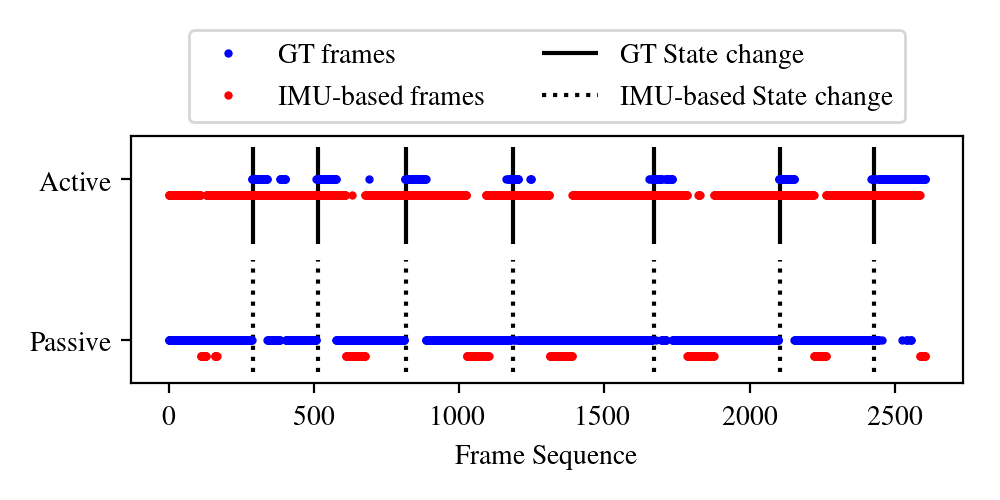

{
    "[[0 2 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 2105, 
    "[[2 2 2 2]]": 291, 
    "[[0 0 1 0]\n [2 2 2 2]]": 514, 
    "[[0 0 1 6]\n [2 2 2 2]]": 817, 
    "[[0 2 2 2]\n [0 2 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 2428, 
    "[[0 0 1 1]\n [0 0 1 6]\n [2 2 2 2]]": 1185, 
    "[[0 0 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 1670
}
{
    "[[0 2 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 2105, 
    "[[2 2 2 2]]": 291, 
    "[[0 0 1 0]\n [2 2 2 2]]": 514, 
    "[[0 0 1 6]\n [2 2 2 2]]": 817, 
    "[[0 2 2 2]\n [0 2 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 2428, 
    "[[0 0 1 1]\n [0 0 1 6]\n [2 2 2 2]]": 1185, 
    "[[0 0 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 1670
}
{
    "[[0 0 1 0]\n [2 2 2 2]]": 0, 
    "[[0 2 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 0, 
    "[[2 2 2 2]]": 0, 
    "[[0 2 2 2]\n [0 2 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 0, 
    "[[0 0 1 6]\n [2 2 2 2]]": 0, 
    "[[0 0 1 1]\n [0 0 1 6]\n [2 2 2 2]]": 0, 
    "[[0 0 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 0
}
lego-tr2
lego-tr2 has 969/2982 active/total frames


<IPython.core.display.Javascript object>


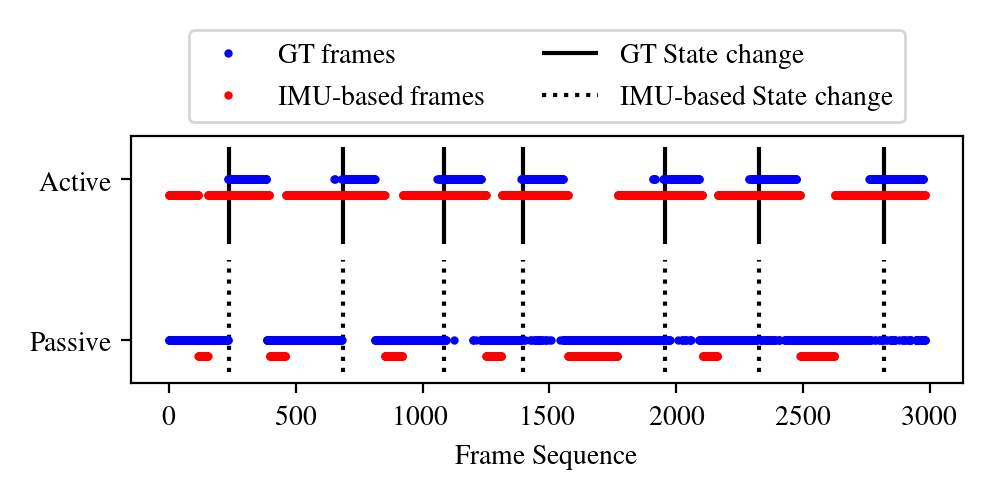

{
    "[[0 2 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 2325, 
    "[[2 2 2 2]]": 239, 
    "[[0 0 1 0]\n [2 2 2 2]]": 687, 
    "[[0 0 1 6]\n [2 2 2 2]]": 1085, 
    "[[0 2 2 2]\n [0 2 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 2820, 
    "[[0 0 1 1]\n [0 0 1 6]\n [2 2 2 2]]": 1396, 
    "[[0 0 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 1955
}
{
    "[[0 2 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 2325, 
    "[[2 2 2 2]]": 239, 
    "[[0 0 1 0]\n [2 2 2 2]]": 687, 
    "[[0 0 1 6]\n [2 2 2 2]]": 1085, 
    "[[0 2 2 2]\n [0 2 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 2820, 
    "[[0 0 1 1]\n [0 0 1 6]\n [2 2 2 2]]": 1396, 
    "[[0 0 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 1955
}
{
    "[[0 0 1 0]\n [2 2 2 2]]": 0, 
    "[[0 2 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 0, 
    "[[2 2 2 2]]": 0, 
    "[[0 2 2 2]\n [0 2 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 0, 
    "[[0 0 1 6]\n [2 2 2 2]]": 0, 
    "[[0 0 1 1]\n [0 0 1 6]\n [2 2 2 2]]": 0, 
    "[[0 0 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 0
}
lego-tr3
lego-tr3 has 962/2858 active/total frames


<IPython.core.display.Javascript object>


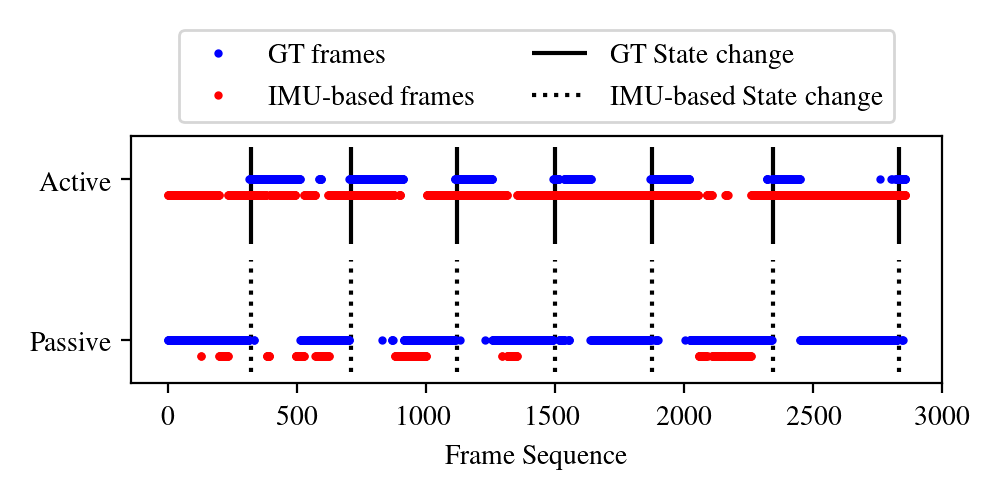

{
    "[[0 2 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 2345, 
    "[[2 2 2 2]]": 321, 
    "[[0 0 1 0]\n [2 2 2 2]]": 708, 
    "[[0 0 1 6]\n [2 2 2 2]]": 1121, 
    "[[0 2 2 2]\n [0 2 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 2832, 
    "[[0 0 1 1]\n [0 0 1 6]\n [2 2 2 2]]": 1498, 
    "[[0 0 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 1876
}
{
    "[[0 2 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 2345, 
    "[[2 2 2 2]]": 321, 
    "[[0 0 1 0]\n [2 2 2 2]]": 708, 
    "[[0 0 1 6]\n [2 2 2 2]]": 1121, 
    "[[0 2 2 2]\n [0 2 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 2832, 
    "[[0 0 1 1]\n [0 0 1 6]\n [2 2 2 2]]": 1498, 
    "[[0 0 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 1876
}
{
    "[[0 0 1 0]\n [2 2 2 2]]": 0, 
    "[[0 2 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 0, 
    "[[2 2 2 2]]": 0, 
    "[[0 2 2 2]\n [0 2 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 0, 
    "[[0 0 1 6]\n [2 2 2 2]]": 0, 
    "[[0 0 1 1]\n [0 0 1 6]\n [2 2 2 2]]": 0, 
    "[[0 0 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 0
}
lego-tr4
lego-tr4 has 736/3110 active/total frames


<IPython.core.display.Javascript object>


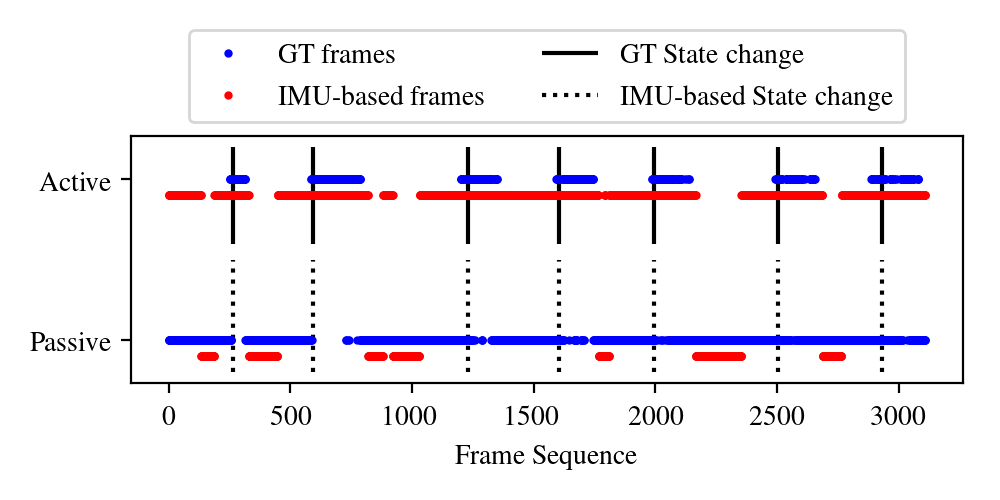

{
    "[[0 2 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 2503, 
    "[[2 2 2 2]]": 263, 
    "[[0 0 1 0]\n [2 2 2 2]]": 594, 
    "[[0 0 1 6]\n [2 2 2 2]]": 1231, 
    "[[0 2 2 2]\n [0 2 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 2930, 
    "[[0 0 1 1]\n [0 0 1 6]\n [2 2 2 2]]": 1604, 
    "[[0 0 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 1993
}
{
    "[[0 2 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 2503, 
    "[[2 2 2 2]]": 263, 
    "[[0 0 1 0]\n [2 2 2 2]]": 594, 
    "[[0 0 1 6]\n [2 2 2 2]]": 1231, 
    "[[0 2 2 2]\n [0 2 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 2930, 
    "[[0 0 1 1]\n [0 0 1 6]\n [2 2 2 2]]": 1604, 
    "[[0 0 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 1993
}
{
    "[[0 0 1 0]\n [2 2 2 2]]": 0, 
    "[[0 2 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 0, 
    "[[2 2 2 2]]": 0, 
    "[[0 2 2 2]\n [0 2 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 0, 
    "[[0 0 1 6]\n [2 2 2 2]]": 0, 
    "[[0 0 1 1]\n [0 0 1 6]\n [2 2 2 2]]": 0, 
    "[[0 0 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 0
}
lego-tr6
lego-tr6 has 1157/4084 active/total frames


<IPython.core.display.Javascript object>


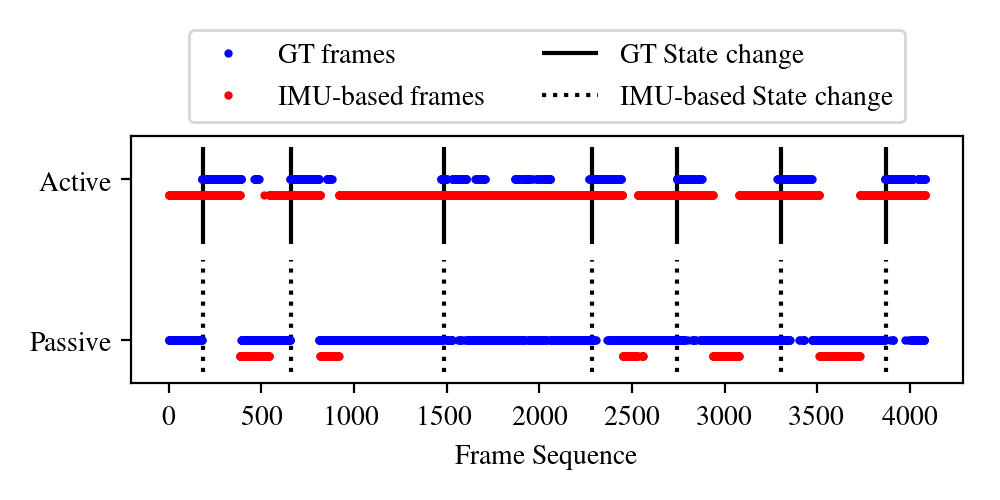

{
    "[[0 2 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 3304, 
    "[[2 2 2 2]]": 184, 
    "[[0 0 1 0]\n [2 2 2 2]]": 661, 
    "[[0 0 1 6]\n [2 2 2 2]]": 1488, 
    "[[0 2 2 2]\n [0 2 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 3871, 
    "[[0 0 1 1]\n [0 0 1 6]\n [2 2 2 2]]": 2285, 
    "[[0 0 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 2746
}
{
    "[[0 2 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 3304, 
    "[[2 2 2 2]]": 184, 
    "[[0 0 1 0]\n [2 2 2 2]]": 661, 
    "[[0 0 1 6]\n [2 2 2 2]]": 1488, 
    "[[0 2 2 2]\n [0 2 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 3871, 
    "[[0 0 1 1]\n [0 0 1 6]\n [2 2 2 2]]": 2285, 
    "[[0 0 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 2746
}
{
    "[[0 0 1 0]\n [2 2 2 2]]": 0, 
    "[[0 2 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 0, 
    "[[2 2 2 2]]": 0, 
    "[[0 2 2 2]\n [0 2 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 0, 
    "[[0 0 1 6]\n [2 2 2 2]]": 0, 
    "[[0 0 1 1]\n [0 0 1 6]\n [2 2 2 2]]": 0, 
    "[[0 0 1 1]\n [0 2 1 6]\n [2 2 2 2]]": 0
}
   change_delay_frames_max  change_delay_frames_mean  dropped_active  \
0    

In [87]:
%matplotlib notebook

clf = pickle.load(open('IMU_' + APP + '_clf.pkl', 'r'))
    
test_set_result = eval_load_and_latency(TEST_TRACES, clf)
test_set_result.to_csv('IMU_result.txt')
print(test_set_result)

pingpong-tr10 has 921/2233 active/total frames
pingpong-tr10 has 921/2233 active/total frames


<IPython.core.display.Javascript object>


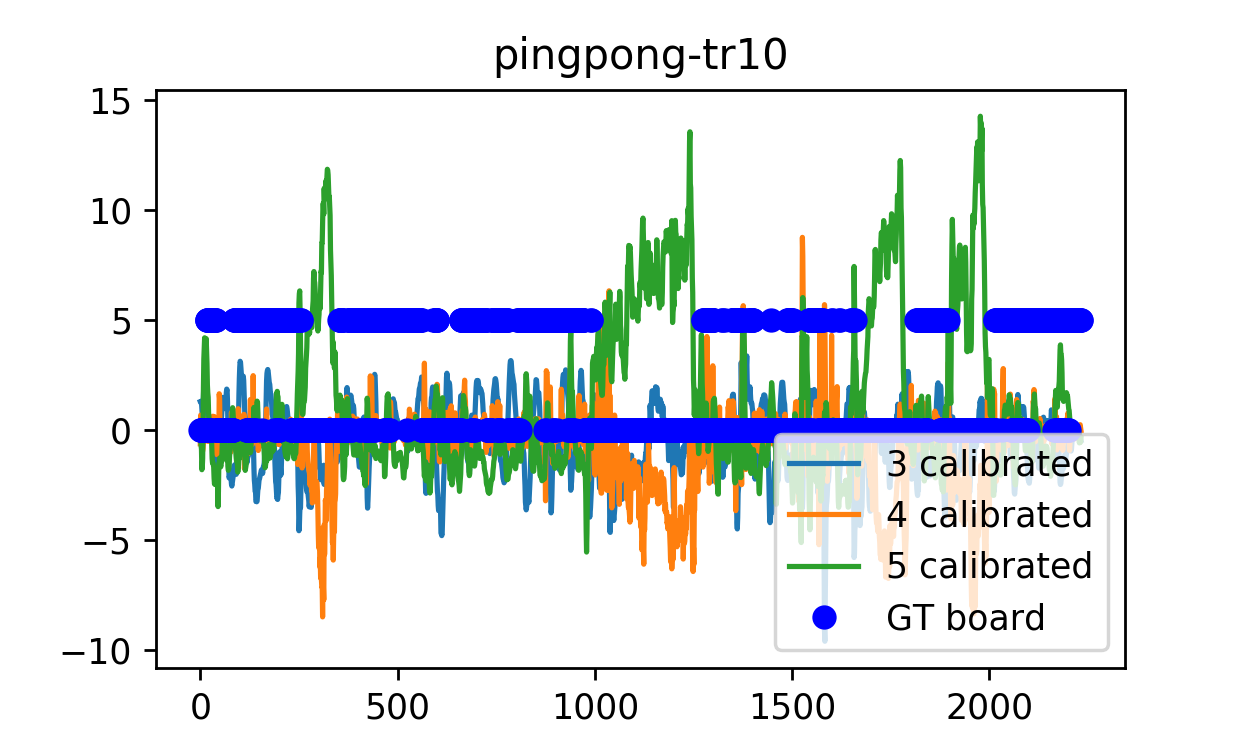

Corr coef:
 [[ 1.          0.19570204]
 [ 0.19570204  1.        ]]
pingpong-tr6 has 2858/6345 active/total frames
pingpong-tr6 has 2858/6345 active/total frames


<IPython.core.display.Javascript object>


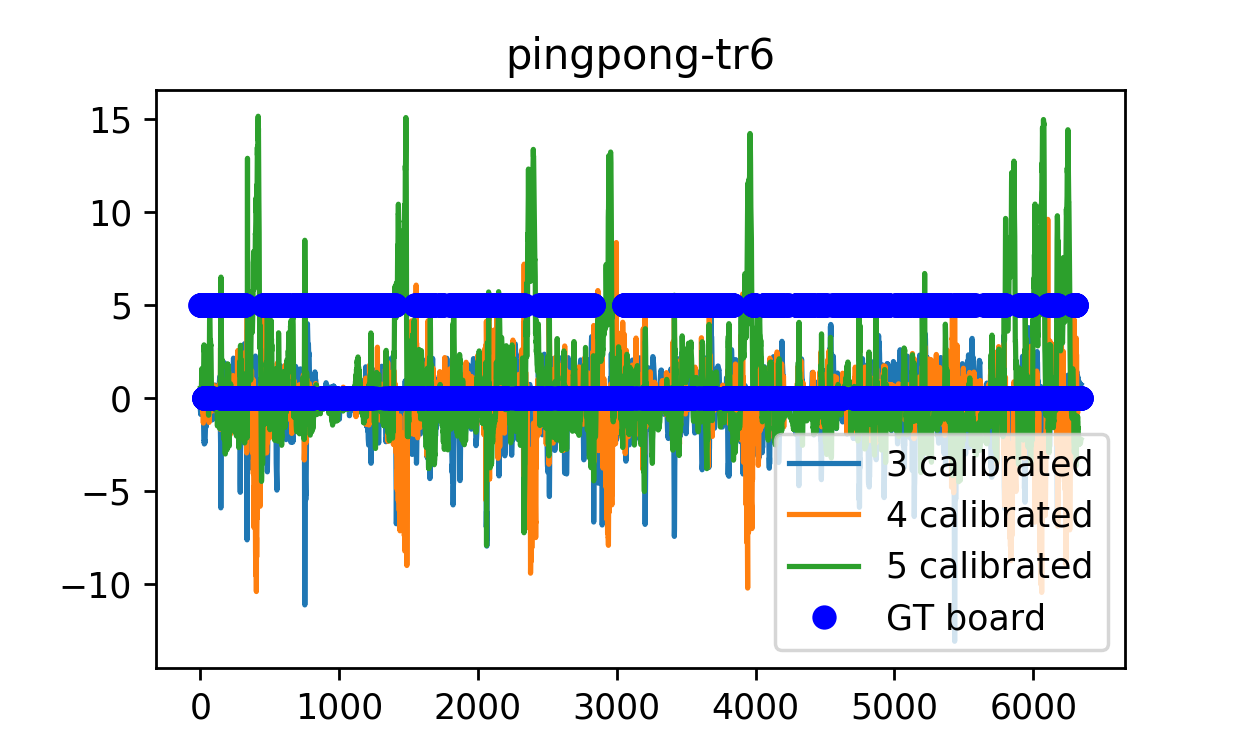

Corr coef:
 [[ 1.          0.07474108]
 [ 0.07474108  1.        ]]
pingpong-tr7 has 2318/6609 active/total frames
pingpong-tr7 has 2318/6609 active/total frames


<IPython.core.display.Javascript object>


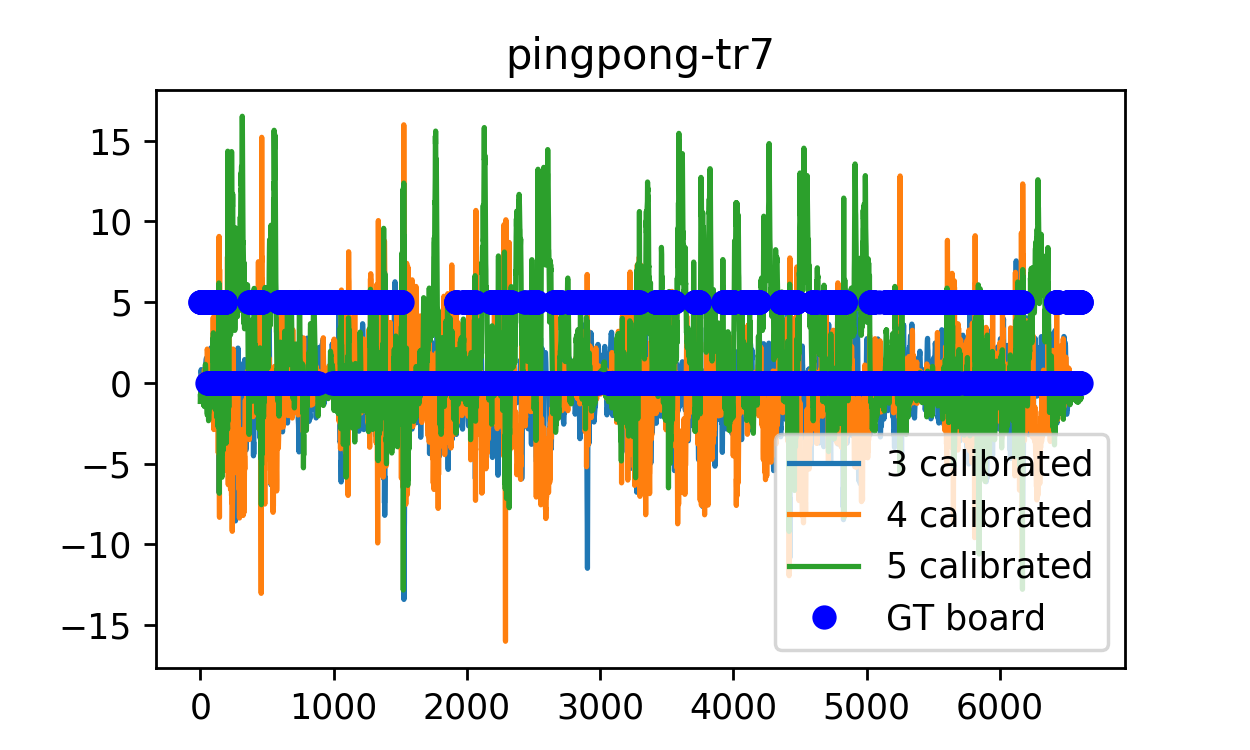

Corr coef:
 [[ 1.          0.12746666]
 [ 0.12746666  1.        ]]
pingpong-tr8 has 3512/7963 active/total frames
pingpong-tr8 has 3512/7963 active/total frames


<IPython.core.display.Javascript object>


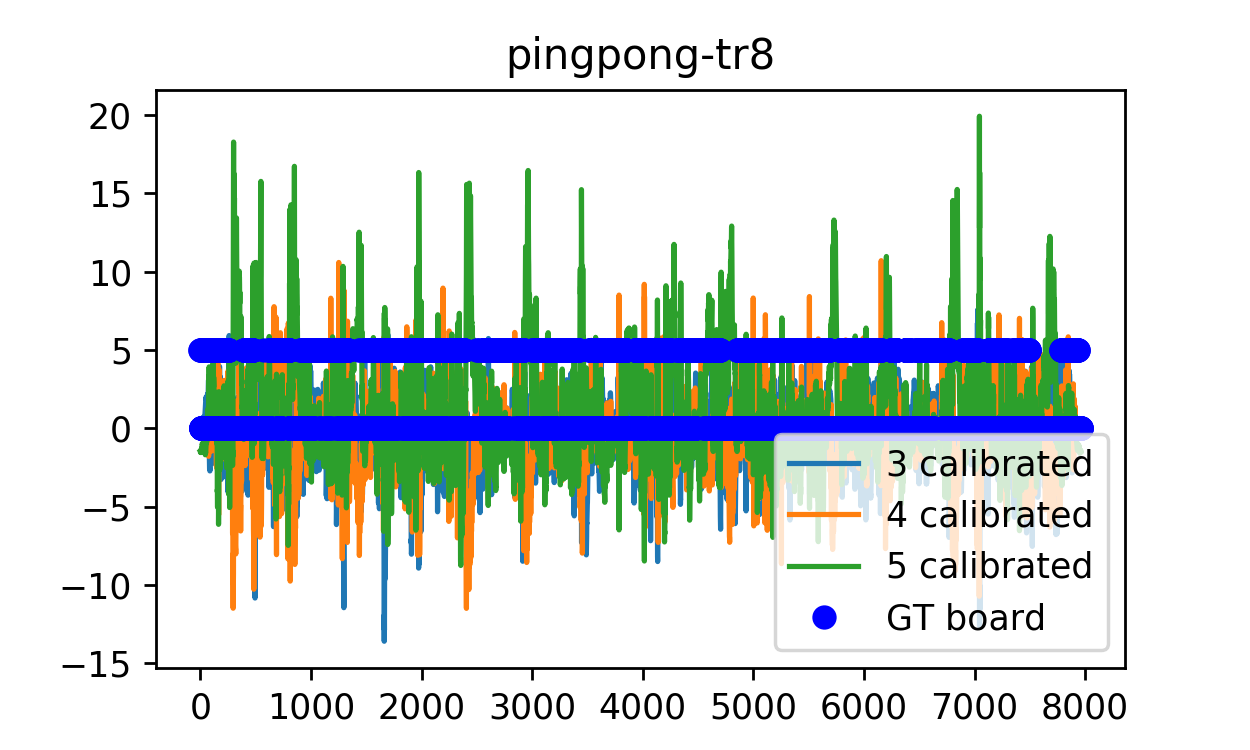

Corr coef:
 [[ 1.          0.12370819]
 [ 0.12370819  1.        ]]
pingpong-tr9 has 4108/8549 active/total frames
pingpong-tr9 has 4108/8549 active/total frames


<IPython.core.display.Javascript object>


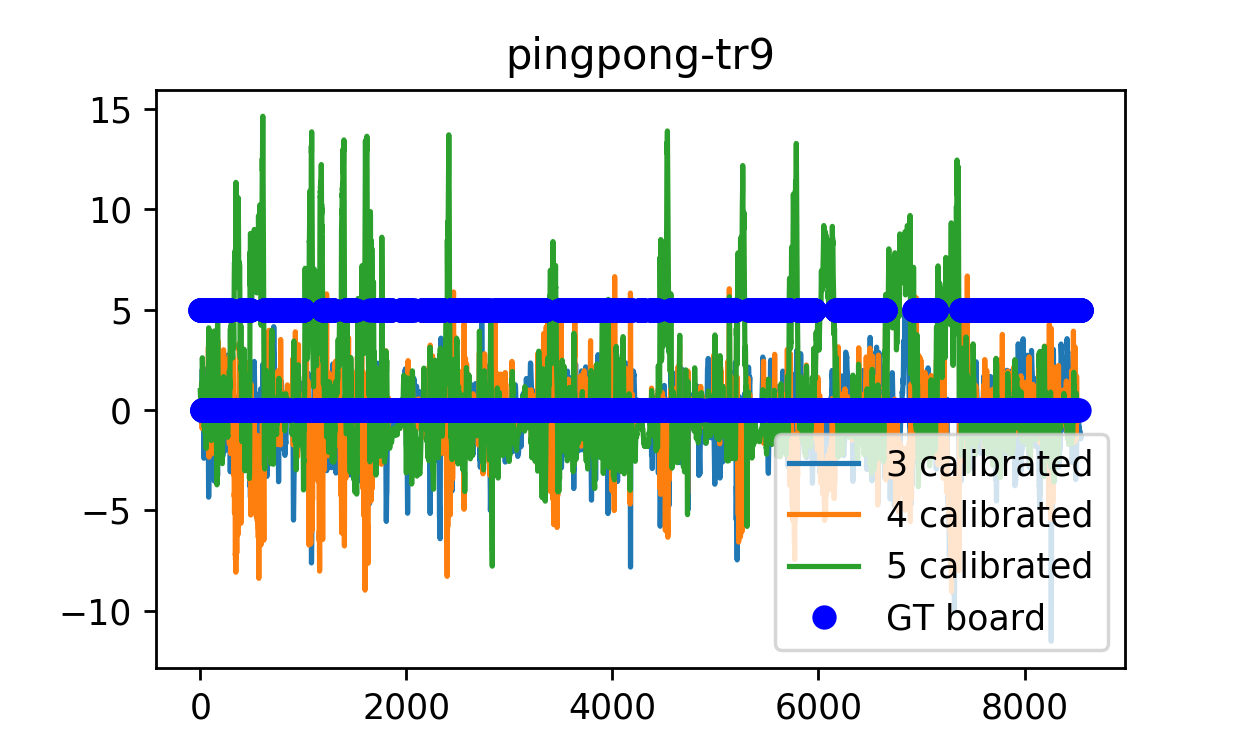

Corr coef:
 [[ 1.          0.16346729]
 [ 0.16346729  1.        ]]


In [10]:
# dirty playground
%matplotlib notebook


for trace_name in sorted(set(TRAIN_TRACES + TEST_TRACES)):
    X, y = get_raw_Xy(trace_name)
    X_uncalibrated, _ = get_raw_Xy(trace_name, calibrate=False)

    X_accx = X[:,3]

    X_smooth = past_windowed_1d(X_accx, 90, lambda w: np.mean(w))

    X_cummin = np.minimum.accumulate(X_smooth)
    X_cummax = np.maximum.accumulate(X_smooth)
    X_cummean = np.cumsum(X_smooth) / (np.arange(X_smooth.shape[0]) + 1)

    # X_star = X_smooth - np.cumsum(X_accx) / (np.arange(X_accx.shape[0]) + 1)
    # X_star = gaussian_filter1d(X_accx,10) - np.mean(X_accx)
    X_star = past_windowed_1d(X_accx, X_accx.shape[0], lambda w: gaussian_filter1d(w, 10)[-1] - np.mean(w))

    y_pred = np.array(X_star < 0.1, dtype=np.int8)

    # hot fix: always transmit first 90 frames (~3 sec)
    y_pred[:90] = 1

    fn_inds = np.nonzero(np.logical_and(y == 1, y_pred == 0))[0]
    fp_inds = np.nonzero(np.logical_and(y == 0, y_pred == 1))[0]


    if True:
        plt.figure(figsize=(5,3))

        for i in range(3, 6):
            plt.plot(X[:,i], label=str(i)+' calibrated')

        plt.plot(y*5, 'bo', label='GT board')
    #     plt.plot(X_accx, 'g', label ='acc x')

    #     plt.plot(X_smooth , 'k', label ='X smooth')
    #     plt.plot(X_cummean, 'c', label='cum mean')
    #     plt.plot(X_smooth < np.mean(X_smooth), label='offset mean')
    #     plt.plot(X_cummin, 'c', label ='X cummax')
    #     plt.plot(X_cummax, 'm', label ='X cummin')
    #     plt.plot(X_star, 'r', label ='acc x (smoothed&normalized)')
    #     plt.plot(gaussian_filter1d(X_accx,10), label='Gaussian smooth')
    #     plt.plot(fn_inds, np.ones_like(fn_inds) , 'yx', label = 'FN')
    #     plt.plot(fp_inds, np.zeros_like(fp_inds) , 'mx', label = 'FP')
        plt.legend(loc='lower right')
        plt.title(trace_name)

    print("Corr coef:\n", np.corrcoef(X_star, y))
